# Donwload the data

In [1]:
!pip install kaggle

In [2]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
import kaggle
import tensorflow as tf
import pandas as pd

In [4]:
import io
import os
import re
import shutil
import string
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import TextVectorization

In [5]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

imdb-dataset-of-50k-movie-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!unzip /content/imdb-dataset-of-50k-movie-reviews.zip

Archive:  /content/imdb-dataset-of-50k-movie-reviews.zip
replace IMDB Dataset.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


# Preprocessing of Data, Tokenization and Numericalization:

In [ ]:
import pandas as pd

In [ ]:
dataset = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
dataset.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 60000
sequence_length = 200

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
#text_ds = dataset.map(lambda x, y: x)
vectorize_layer.adapt(dataset.review)

In [ ]:
len(vectorize_layer.get_vocabulary())

60000

In [ ]:
input_data = ["This is an example sentence"]
transformed_data = vectorize_layer(input_data)
print(transformed_data)

tf.Tensor(
[[  11    7   33  462 3813    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0  

In [ ]:
embedding_layer = tf.keras.layers.Embedding(60000, 16)

In [ ]:
embedding_layer(transformed_data).shape

TensorShape([1, 200, 16])

In [ ]:
Labels = []
for i in range(len(dataset.sentiment)):
  if dataset.sentiment[i] == "positive":
    Labels.append(1)
  else:
    Labels.append(0)

In [ ]:
df = pd.DataFrame({'Column1': dataset.sentiment, 'Column2': Labels})

In [ ]:
df.head()

,Column1,Column2
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


In [ ]:
Inputs = vectorize_layer(dataset.review)

In [ ]:
Labels = df.Column2

In [ ]:
# Create a TensorFlow dataset from the vectorized data
Inputs = tf.data.Dataset.from_tensor_slices(Inputs)
Labels = tf.data.Dataset.from_tensor_slices(Labels)

In [ ]:
dataset = tf.data.Dataset.zip((Inputs, Labels))
dataset

<_ZipDataset element_spec=(TensorSpec(shape=(200,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [ ]:
#Training and Validation data split :
dataset = dataset.shuffle(len(dataset))
train_size = int(0.8 * len(dataset))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [ ]:
batch_size = 128

# Batch the dataset
train_dataset = train_dataset.batch(batch_size)
val_dataset = val_dataset.batch(batch_size)

In [ ]:
len(train_dataset)

313

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# RNN Long Short Term Memory

In [ ]:
Model = Sequential([
    tf.keras.layers.Embedding(input_dim=len(vectorize_layer.get_vocabulary()),output_dim=128, input_length=200),
    tf.keras.layers.LSTM(128,activation = "tanh", return_sequences=True),
    tf.keras.layers.LSTM(128,activation = "tanh"),
    tf.keras.layers.Dense(128,activation = "tanh"),
    tf.keras.layers.Dense(1,activation = "sigmoid")
    ])

In [ ]:
#Learning rate scheduler:
def LR_scheduler(epoch):
    lr = 0.0005
    lr = lr*(1-0.4)**(epoch)
    return lr

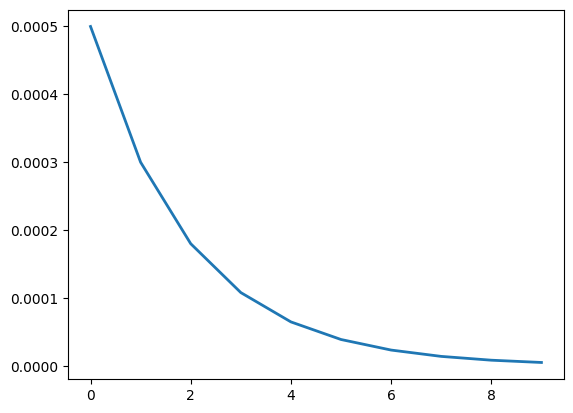

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = []
y = []
for epoch in range(10):
  y.append(LR_scheduler(epoch))
  x.append(epoch)

fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)


plt.show()

In [ ]:
y

[0.0005,
 0.0003,
 0.00017999999999999998,
 0.00010799999999999998,
 6.48e-05,
 3.8879999999999994e-05,
 2.3327999999999994e-05,
 1.3996799999999998e-05,
 8.398079999999997e-06,
 5.038847999999999e-06]

In [ ]:
Model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(LR_scheduler)

In [ ]:
Model.fit(train_dataset,epochs=10,callbacks=[callback],validation_data=val_dataset)

Epoch 1/10
313/313 [==============================] - 73s 203ms/step - loss: 0.4891 - accuracy: 0.7323 - val_loss: 0.2329 - val_accuracy: 0.9138 - lr: 5.0000e-04
Epoch 2/10
313/313 [==============================] - 10s 32ms/step - loss: 0.2156 - accuracy: 0.9197 - val_loss: 0.1750 - val_accuracy: 0.9390 - lr: 3.0000e-04
Epoch 3/10
313/313 [==============================] - 10s 32ms/step - loss: 0.1357 - accuracy: 0.9546 - val_loss: 0.1460 - val_accuracy: 0.9526 - lr: 1.8000e-04
Epoch 4/10
313/313 [==============================] - 10s 32ms/step - loss: 0.0901 - accuracy: 0.9740 - val_loss: 0.1265 - val_accuracy: 0.9632 - lr: 1.0800e-04
Epoch 5/10
313/313 [==============================] - 10s 33ms/step - loss: 0.0670 - accuracy: 0.9833 - val_loss: 0.1250 - val_accuracy: 0.9671 - lr: 6.4800e-05
Epoch 6/10
313/313 [==============================] - 10s 32ms/step - loss: 0.0529 - accuracy: 0.9882 - val_loss: 0.1198 - val_accuracy: 0.9693 - lr: 3.8880e-05
Epoch 7/10
313/313 [=============

# Validation of training

In [ ]:
Model.evaluate(val_dataset)

79/79 [==============================] - 1s 12ms/step - loss: 0.1198 - accuracy: 0.9700


[0.11978285014629364, 0.9700000286102295]

In [ ]:
predictions = Model.predict(val_dataset)

79/79 [==============================] - 1s 10ms/step


In [ ]:
predictions

array([[0.00259744],
       [0.011048  ],
       [0.00149299],
       ...,
       [0.9980856 ],
       [0.9976526 ],
       [0.03005823]], dtype=float32)

In [ ]:
predictions = np.round(predictions).astype(int).flatten().tolist()

print(predictions)

[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 

In [ ]:
Real_predictions = []

for _, outputs in val_dataset:
    Real_predictions.extend(outputs.numpy().tolist())

print(Real_predictions)

[0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 

In [ ]:
j = 0
n = 0
for i in range(len(predictions)):
  if predictions[i] == Real_predictions[i]:
    j = j + 1
  else:
    n = n + 1


print("There are: ", j ," True predictions")
print("There are: ", n ," False predictions")
print("Accuracy = ",j/(j+n),"%")

There are:  9700  True predictions
There are:  300  False predictions
Accuracy =  0.97 %


# **Bert Fine-Tuning**

# Bert Preprocessing

In [ ]:
!pip install tensorflow-text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 524.1/524.1 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 70.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 47.3 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.7.1
    Uninstalling typing_extensions-4.7.1:
      Successfully uninstalled typing_extensions-4.7.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstalled tensorflow-estimator-2.12.0
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorboard
    Fou

In [ ]:
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow as tf

We can choose one of these models to fine-tune
;In our case we will choose the small Bert

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [ ]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262873  0.9928099  -0.18611872  0.36673853  0.1523371   0.65504426
  0.9681154  -0.94862705  0.00216182 -0.9877732   0.06842728 -0.97630584]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946307  0.34321266  0.33231518 ...  0.21300897  0.71020764
  -0.05771176]
 [-0.2874206   0.3198098  -0.23018597 ...  0.5845501  -0.21329726
   0.72692066]
 [-0.6615712   0.68876785 -0.8743292  ...  0.10877268 -0.2617322
   0.4785534 ]
 ...
 [-0.22561154 -0.28925663 -0.07064398 ...  0.47566003  0.8327717
   0.40025344]
 [-0.29824272 -0.27473173 -0.05450511 ...  0.48849759  1.0955356
   0.18163322]
 [-0.44378266  0.00930682  0.07223728 ...  0.17290092  1.1833241
   0.07898061]]


In [ ]:
import pandas as pd
dataset = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
Labels = []
for i in range(len(dataset.sentiment)):
  if dataset.sentiment[i] == "positive":
    Labels.append(1)
  else:
    Labels.append(0)

In [ ]:
Inputs = []
for text in dataset.review:
  Inputs.append([text])

In [ ]:
import numpy as np

In [ ]:
Inputs = np.array(Inputs)
Labels = np.array(Labels)

In [ ]:
Inputs.shape

(50000, 1)

In [ ]:
Labels.shape

(50000,)

In [ ]:
Labels = Labels.reshape(-1,1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(Inputs, Labels, test_size=0.2, random_state=42,shuffle = True)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

# Convert the numpy arrays back to TensorFlow tensors
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))

train_dataset=train_dataset.batch(200)
val_dataset=val_dataset.batch(200)

# Apply caching and prefetching
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.cache().prefetch(buffer_size=AUTOTUNE)

# Build the model and training

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.5)(net)
  net = tf.keras.layers.Dense(1, activation="sigmoid", kernel_regularizer=tf.keras.regularizers.l2(0.01), name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
Model = build_classifier_model()
bert_raw_result = Model(tf.constant(text_test))
print(bert_raw_result)

tf.Tensor([[0.19532844]], shape=(1, 1), dtype=float32)


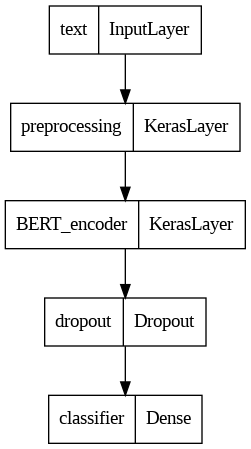

In [ ]:
tf.keras.utils.plot_model(Model)

In [ ]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)

In [ ]:
#Learning rate scheduler:
def LR_scheduler(epoch):
    lr = 5e-5
    lr = lr*(1-0.1)**(epoch)
    return lr

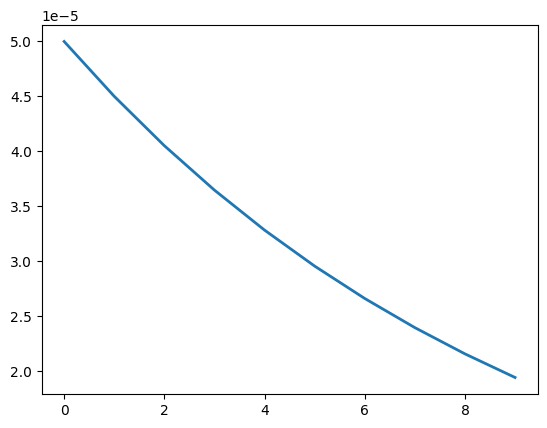

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = []
y = []
for epoch in range(10):
  y.append(LR_scheduler(epoch))
  x.append(epoch)

fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)


plt.show()

In [ ]:
Model.compile(optimizer=tf.keras.optimizers.AdamW(),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits = False),
              metrics=["accuracy"])

In [ ]:
callback = tf.keras.callbacks.LearningRateScheduler(LR_scheduler)

In [ ]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1), dtype=tf.string, name=None), TensorSpec(shape=(None, 1), dtype=tf.int64, name=None))>

In [ ]:
Model.fit(train_dataset,epochs=10,callbacks=[callback],validation_data=val_dataset)

Epoch 1/10
200/200 [==============================] - 604s 3s/step - loss: 0.4919 - accuracy: 0.7729 - val_loss: 0.3621 - val_accuracy: 0.8473 - lr: 5.0000e-05
Epoch 2/10
200/200 [==============================] - 600s 3s/step - loss: 0.3468 - accuracy: 0.8574 - val_loss: 0.3490 - val_accuracy: 0.8592 - lr: 4.5000e-05
Epoch 3/10
200/200 [==============================] - 584s 3s/step - loss: 0.2878 - accuracy: 0.8866 - val_loss: 0.3724 - val_accuracy: 0.8646 - lr: 4.0500e-05
Epoch 4/10
200/200 [==============================] - 633s 3s/step - loss: 0.2337 - accuracy: 0.9148 - val_loss: 0.3892 - val_accuracy: 0.8682 - lr: 3.6450e-05
Epoch 5/10
200/200 [==============================] - 584s 3s/step - loss: 0.1839 - accuracy: 0.9354 - val_loss: 0.4445 - val_accuracy: 0.8716 - lr: 3.2805e-05
Epoch 6/10
200/200 [==============================] - 585s 3s/step - loss: 0.1511 - accuracy: 0.9483 - val_loss: 0.4966 - val_accuracy: 0.8641 - lr: 2.9525e-05
Epoch 7/10
200/200 [====================

We can see that the best generalized result is an accuracy of 86% and we recommand stoping the training at the third epoch.

This bert model suffers form the overfitting compared to RNN-LSTM, and this can be solved by fine tnining the hyperparameters and also trying the original BERT model.

# Validation

In [ ]:
Model.evaluate(val_dataset)

In [ ]:
predictions = Model.predict(val_dataset)

In [ ]:
predictions = np.round(predictions).astype(int).flatten().tolist()

print(predictions)

In [ ]:
Real_predictions = []

for _, outputs in val_dataset:
    Real_predictions.extend(outputs.numpy().tolist())

print(Real_predictions)

In [ ]:
j = 0
n = 0
for i in range(len(predictions)):
  if predictions[i] == Real_predictions[i]:
    j = j + 1
  else:
    n = n + 1


print("There are: ", j ," True predictions")
print("There are: ", n ," False predictions")
print("Accuracy = ",j/(j+n),"%")

# **Training Transformer from scratch**

# Preprocessing Data

In [7]:
import pandas as pd
dataset = pd.read_csv('/content/IMDB Dataset.csv')

In [8]:
# Create a custom standardization function to strip HTML break tags '<br />'.
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation), '')


# Vocabulary size and number of words in a sequence.
vocab_size = 60000
sequence_length = 200

# Use the text vectorization layer to normalize, split, and map strings to
# integers. Note that the layer uses the custom standardization defined above.
# Set maximum_sequence length as all samples are not of the same length.
vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

# Make a text-only dataset (no labels) and call adapt to build the vocabulary.
#text_ds = dataset.map(lambda x, y: x)
vectorize_layer.adapt(dataset.review)

In [9]:
Inputs = vectorize_layer(dataset.review)

In [10]:
Labels = []
for i in range(len(dataset.sentiment)):
  if dataset.sentiment[i] == "positive":
    Labels.append(1)
  else:
    Labels.append(0)

In [11]:
len(Labels)

50000

In [12]:
Inputs.shape

TensorShape([50000, 200])

In [13]:
# Create a TensorFlow dataset from the vectorized data
Inputs = tf.data.Dataset.from_tensor_slices(Inputs)
Labels = tf.data.Dataset.from_tensor_slices(Labels)

In [14]:
dataset = tf.data.Dataset.zip((Inputs, Labels))
dataset

<_ZipDataset element_spec=(TensorSpec(shape=(200,), dtype=tf.int64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [15]:
#Training and Validation data split :
dataset = dataset.shuffle(len(dataset))
train_size = int(0.8 * len(dataset))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)

In [16]:
i = 0
for _, l in train_dataset:
  i= i +1
print(i)

40000


In [17]:
batch_size = 200
AUTOTUNE = tf.data.AUTOTUNE
# Batch the dataset
train_dataset = train_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(batch_size).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
i = 0
for _, l in train_dataset:
  i= i +1
print(i)

200


# Positional Embedding

In [19]:
import numpy as np

In [20]:
def positional_encoding(length, depth):
  depth = depth/2

  positions = np.arange(length)[:, np.newaxis]     # (seq, 1)
  depths = np.arange(depth)[np.newaxis, :]/depth   # (1, depth)

  angle_rates = 1 / (10000**depths)         # (1, depth)
  angle_rads = positions * angle_rates      # (pos, depth)

  pos_encoding = np.concatenate(
      [np.sin(angle_rads), np.cos(angle_rads)],
      axis=-1)

  return tf.cast(pos_encoding, dtype=tf.float32)

In [21]:
class PositionalEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, d_model, length):
    super().__init__()
    self.d_model = d_model
    self.length = length
    self.embedding = tf.keras.layers.Embedding(vocab_size, d_model, mask_zero=True)
    self.pos_encoding = positional_encoding(length = self.length, depth=self.d_model)

  def compute_mask(self, *args, **kwargs):
    return self.embedding.compute_mask(*args, **kwargs)

  def call(self, x):
    length = tf.shape(x)[1]
    x = self.embedding(x)
    # This factor sets the relative scale of the embedding and positonal_encoding.
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x = x + self.pos_encoding[tf.newaxis, :length, :]
    return x

In [22]:
for review,_ in train_dataset:
  break

In [39]:
review

<tf.Tensor: shape=(200, 200), dtype=int64, numpy=
array([[  883,    85,   121, ...,    45,    74,  2091],
       [  539,    42,    11, ...,    33,  3782,   413],
       [ 6506,   693,  1571, ...,     0,     0,     0],
       ...,
       [    2,    60,   280, ...,     0,     0,     0],
       [  104,  1138,  2725, ...,  1040, 16831,    94],
       [   10, 31240,   425, ...,     0,     0,     0]])>

In [23]:
Embedding = PositionalEmbedding(vocab_size = len(vectorize_layer.get_vocabulary()), d_model = 512, length = 2048)
emb_out = Embedding(review)

In [24]:
print(review.shape,emb_out.shape)   #((batch,tokens) (batch,tokens,embedding vector))

(200, 200) (200, 200, 512)


# Transformer - Encoder architecture

In [25]:
import tensorflow as tf

In [26]:
class Head(tf.keras.Model):
  def __init__(self,head_size,num_heads):
    super().__init__()
    self.key = tf.keras.layers.Dense(head_size)
    self.query = tf.keras.layers.Dense(head_size)
    self.value = tf.keras.layers.Dense(head_size)
    self.sm = tf.keras.layers.Softmax()
    self.dropout = tf.keras.layers.Dropout(0.2)
    self.num_heads = num_heads

  def call(self,x):
    out = []
    B,T,C = x.shape
    for _ in range(self.num_heads):
      k = self.key(x)
      Q = self.query(x)
      V = self.value(x)
      #print(V.shape)
      wei = Q @ tf.transpose(k,perm=[0,2,1]) * C**-0.5
      wei = self.sm(wei)
      #print(wei.shape)
      wei = wei @ V
      out.append(wei)
    out = tf.concat([out[i] for i in range(self.num_heads)], axis=2)
    #print(out.shape)
    return out

In [27]:
heads = Head(2,3)
matrix_data = [[[1, 2, 3], [4, 5, 6]],[[1, 2, 3], [4, 5, 6]]]
x = tf.constant(matrix_data, dtype=tf.float32)
print(x.shape)
heads(x).shape
#We need to choose num of heads and head_size in order to gives us the same shape of input (B,T,C)

(2, 2, 3)


TensorShape([2, 2, 6])

In [28]:
class MultiHeadAttention(tf.keras.Model):
  def __init__(self, num_heads, head_size,n_embd,dropout):
    super().__init__()
    self.heads = Head(head_size,num_heads)
    self.proj = tf.keras.layers.Dense(n_embd)
    self.dropout = tf.keras.layers.Dropout(dropout)
    self.head_size = head_size

  def call(self, x):
    x = self.heads(x)
    #x = self.heads(x)  #To add this you need to ensure that the output of the multi head equal the input
    x = self.dropout(self.proj(x))
    return x

In [29]:
Model = MultiHeadAttention(5,10,10,0.2)
matrix_data = [[[1, 2, 3], [4, 5, 6]],[[1, 2, 3], [4, 5, 6]]]
x = tf.constant(matrix_data, dtype=tf.float32)
print(x.shape)
Model(x).shape
#We need to choose num of heads and head_size in order to gives us the same shape of input (B,T,C)

(2, 2, 3)


TensorShape([2, 2, 10])

In [30]:
class FeedForward(tf.keras.Model):
  def __init__(self,n_embd,dropout):
    super().__init__()
    self.net = tf.keras.Sequential([
               tf.keras.layers.Dense(4 * n_embd),
               tf.keras.layers.ReLU(),
               tf.keras.layers.Dense(n_embd),
               tf.keras.layers.ReLU(),
               tf.keras.layers.Dense(1,activation = "sigmoid"),
               tf.keras.layers.Dropout(dropout)])
  def call(self, x):
    return self.net(x)

In [31]:
class Block(tf.keras.Model):
  def __init__(self,num_heads,n_embd,dropout1,dropout2):
    super(Block,self).__init__()
    self.head_size = n_embd // num_heads
    self.sa = MultiHeadAttention(num_heads, self.head_size,n_embd,dropout1)
    self.ffwd = FeedForward(n_embd,dropout2)
    self.ln1 = tf.keras.layers.LayerNormalization()
    self.ln2 = tf.keras.layers.LayerNormalization()
    self.flatten = tf.keras.layers.Flatten()
    self.linear = tf.keras.layers.Dense(1,activation = "sigmoid")
    self.Embedding = PositionalEmbedding(vocab_size = 60000, d_model = 512, length = 2048)

  def call(self,x):
    x = self.Embedding(x)
    x = x + self.sa(self.ln1(x))
    #We need a flatten layer
    x = x + self.ffwd(self.ln2(x))
    x = self.flatten(x)
    #print(x.shape)
    x = self.linear(x)
    return x


In [32]:
Model = Block(8,512,0.2,0.2)
matrix_data = [[[1, 2, 3,4], [4, 5, 6,7]],[[1, 2, 3,4], [4, 5, 6,7]]]
x = tf.constant(matrix_data, dtype=tf.float32)
print(x.shape)
Model(review).shape
#We need to choose num of heads and head_size in order to gives us the same shape of input (B,T,C)

(2, 2, 4)


TensorShape([200, 1])

In [33]:
lossclass = tf.keras.losses.BinaryCrossentropy()

In [34]:
optimizer = tf.keras.optimizers.AdamW(learning_rate = 1e-5)

In [72]:
num_epochs = 20
for epoch in range(num_epochs):
 i = 0
 v = 0
 j = 0
 totalloss = 0
 Number_of_data = 0
 l = 0
 n = 0
 Number_of_test_data = 0
 for inputs, targets in train_dataset:

    with tf.GradientTape() as tape:
        output = Model(inputs)

        # Compute the loss
        loss = lossclass(targets, output)

    # Compute gradients
    gradients = tape.gradient(loss, Model.trainable_variables)

    # Update the weights
    optimizer.apply_gradients(zip(gradients, Model.trainable_variables))
    totalloss += loss
    for j in range(len(output)):
      if targets[j] == tf.cast(tf.round(output), dtype=tf.int32).numpy()[j]:
        v = v+1
    i += 1
    Number_of_data += len(output)

 for test_inputs ,test_targets in val_dataset:
   test_output = Model(test_inputs)
   for j in range(len(test_output)):
     if test_targets[j] == tf.cast(tf.round(test_output), dtype=tf.int32).numpy()[j]:
        l = l+1
     n +=1
   Number_of_test_data += len(test_output)

 val_accuracy = l/Number_of_test_data
 accuracy = v/(Number_of_data)
 print(f"Epoch {epoch+1}: Loss = {totalloss / i}, number of batch in the data : {i} ,Number of data: {Number_of_data}, accuracy: {accuracy},val_accuracy: {val_accuracy}")

Epoch 1: Loss = 0.1564716398715973, number of batch in the data : 200 ,Number of data: 40000, accuracy: 0.948925,val_accuracy: 0.9371
Epoch 2: Loss = 0.13516134023666382, number of batch in the data : 200 ,Number of data: 40000, accuracy: 0.95775,val_accuracy: 0.9454
Epoch 3: Loss = 0.11602993309497833, number of batch in the data : 200 ,Number of data: 40000, accuracy: 0.964975,val_accuracy: 0.9507
Epoch 4: Loss = 0.09918622672557831, number of batch in the data : 200 ,Number of data: 40000, accuracy: 0.9716,val_accuracy: 0.9556
Epoch 5: Loss = 0.08565936237573624, number of batch in the data : 200 ,Number of data: 40000, accuracy: 0.97645,val_accuracy: 0.9602
Epoch 6: Loss = 0.07874328643083572, number of batch in the data : 200 ,Number of data: 40000, accuracy: 0.97775,val_accuracy: 0.9303
Epoch 7: Loss = 0.08450919389724731, number of batch in the data : 200 ,Number of data: 40000, accuracy: 0.97195,val_accuracy: 0.9647
Epoch 8: Loss = 0.06490463018417358, number of batch in the da

In [101]:
text = "the only beautiful thing in this movie is the CGI"

In [102]:
tex = vectorize_layer(text)

In [103]:
tex = tf.expand_dims(tex, axis=0)

In [104]:
if tf.round(Model(tex)) == 1:
  print("Positive review")
else:
  print("Negative review")

Negative review
